# Training Optimizations

## Overview

A very nice diagram from Weng and Brockman illustrating the different kinds of parallelization techniques

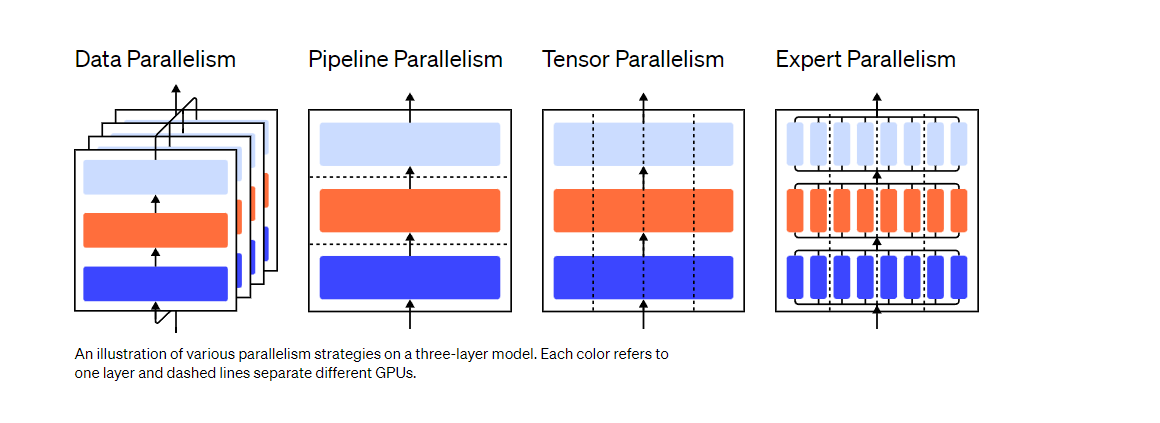




Just as in the diagram above

4 main ideas

1) Data parallelism - Every GPU has the entire model/network loaded, the data gets split across multiple GPU's
2) Pipeline parallelism - Different layers of the NN go to different GPUs. Obviously this means that once a specific layer is complete, output from the layer should be shifted to another layer
3) Tensor parallelism - Tensor operations within a layer are split across multiple GPU's (ie break up the math for a single operation such as a matrix multiplication to be split across GPUs)
4) Mixture of Experts parallelism - process each example by only a fraction of each layer.





## Data Parallelism

Copy the same model/parameters totally to multiple GPU's, and assign different examples for training to each GPU. Training happens in parallel across the multiple GPUs (also called workers)

Because the entire model is used on every GPU
This requires
1) The model to fit on the memory of a single GPU
2) Multiple copies of the model to be copied, one for every GPU

So GPU RAM is Swamped !!

Some optimizations do exist here to get over this problem,such as temporarily offloading some of the parameters to CPU between usages

Because training happens in parallel across multiple GPU's, and gradients are computed separately per GPU, there needs to be a way to syncthe gradients across all the GPU's as training goes on.

The simplest approach is to introduce blocking communication between workers

1) Independently compute gradients for each worker/GPU
2) Average gradients across workers (using [all reduce](https://tech.preferred.jp/en/blog/technologies-behind-distributed-deep-learning-allreduce/))
3) Uses the averaged gradients to independently update parameters/weights for each worker to get the same final weights in each worker


Note that step 2) is a blocking step requiring a tonne of data transfer between workers (O(number of GPUs * no of parameters). There are async variations, but these are not popular in practice

## Pipeline parallelism

In pipeline parallelism, as discussed, sequential chunks of models (layers) are partitioned  across GPUs

So each GPU gets a fraction of the total model weights, reducing GPU memory, which is nice

However, Each layer's input now depends on the output of the prev layer which sits on a different machine

So we have to be careful  - naive implementations can make the NN wait (each layer waits for a long time to receive the output of a prev layer, called bubbles), wasting computation and lowering throughput

Naive implementation causing bubbles

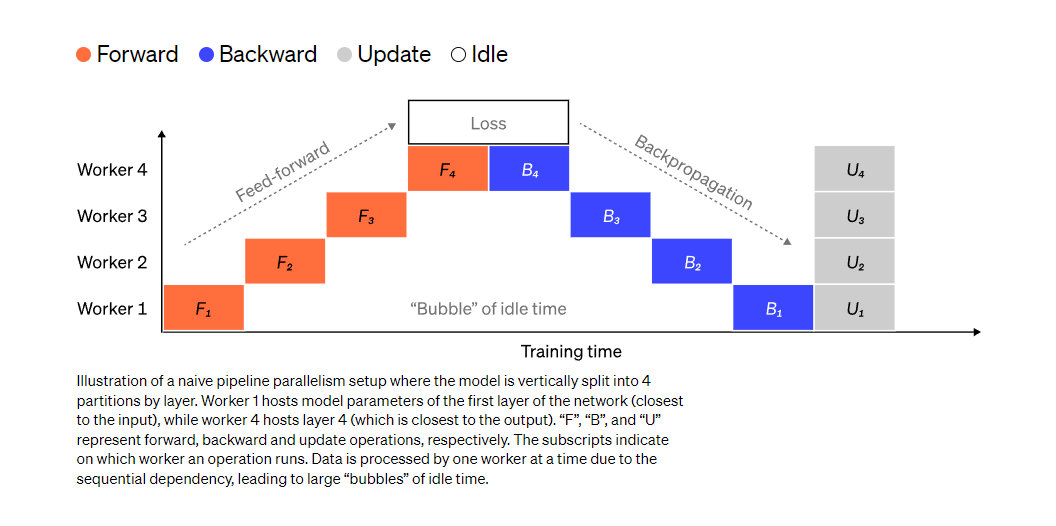

To reduce bubble time/waiting time, the idea is to split a batch into microbatches,
so let's say batch1 is split into microbatch 1,2,3

worker 2 / gpu 2 is feedforwarding or backprop data in microbatch 1. As soon as this is done, it passes output to next layer (gpu3 for feedforwarding, gpu1 for backprop, for example); and gpu2 can start processing the next microbatch

So there is an overlap of new computation with wait time

As we increase the no of microbatches, this reduces wait time to a very small number (just the initial warming up and the final cooling down phase)

Gradients are averaged across microbatches, and updates to the parameters happen only once all microbatches have been completed

There are design variations on how to schedule the forward and backward passes and how to aggregate the gradients across microbatches

 GPipe has each worker process forward and backward passes consecutively and then aggregates gradients from multiple microbatches synchronously at the end. PipeDream instead schedules each worker to alternatively process forward and backward passes.
 
 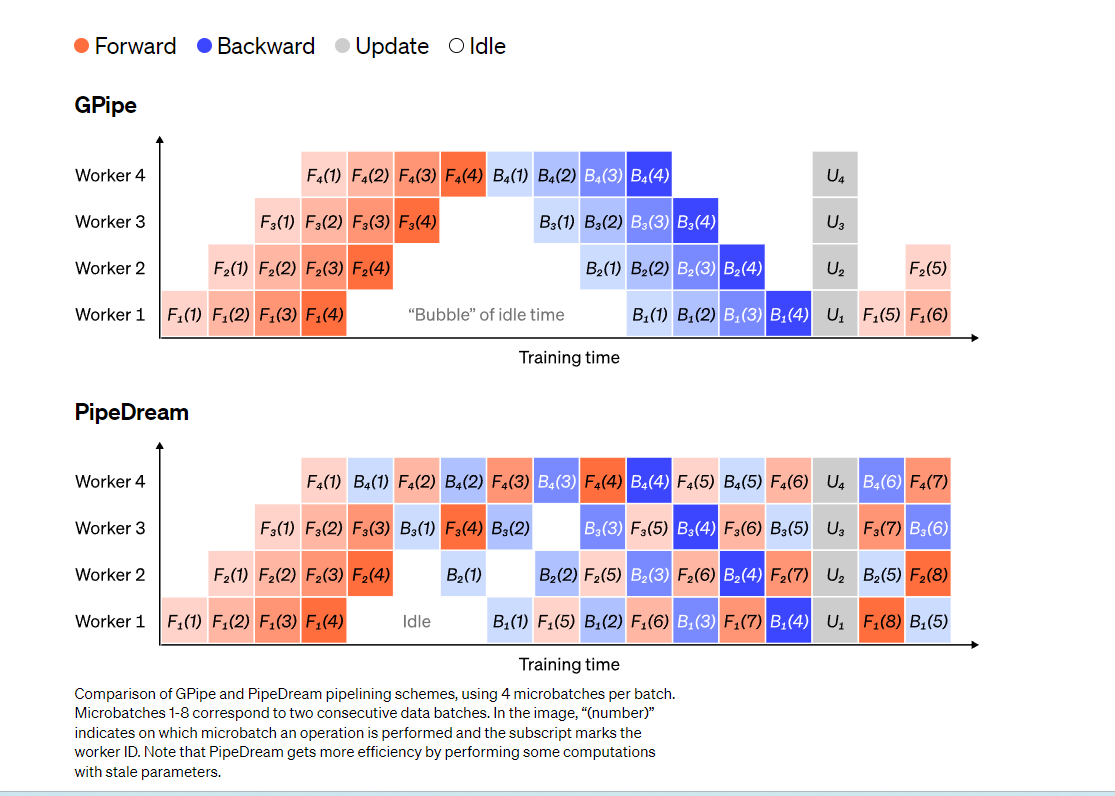

## Tensor parallelism (Also called model parallelism)

Here, as mentioned earlier, parallelism is even within a layer

Specifically, matrix multiplication (between weights and activations, between Q and K) are some of the most time consuming steps

This can be thought as separate R<sup>T</sup>col calculations (each element in a matrix  multiplication is R<sup>T</sup>col computation of a different pair of row and columns)


We can even compute parts of the dot product on one GPU, parts on another, and sum
So each of these computations can happen on a separate worker/GPU !!

we can slice the weight matrix into even-sized “shards”, host each shard on a different GPU, and use that shard to compute the relevant part of the overall matrix product before later communicating to combine the results.

So this again means that GPU only stores a small fraction of the weights

Examples are Megatron-LM, 

 PTD-P uses tensor, data, and pipeline parallelism; its pipeline schedule assigns multiple non-consecutive layers to each device, reducing bubble overhead at the cost of more network communication.
 
Another related idea is sequence parallelism, where the input sequence is split across time to form different examples

https://arxiv.org/abs/2205.05198

Tensor parallelism requires significant communication between each layer. As a result,
they work well within a single node where the inter-GPU communication bandwidth is high,
but the efficiency degrades quickly beyond a single node

## Mixture of Experts

IMO more an architectural innovation than an engineering solution
only a fraction of the network is used to compute the output for any one input

For example, have many sets of weights and the network can choose which set to use via a gating mechanism at inference time. Each set of weights is referred to as “experts, and each expert can be on a different GPU

This allows a lot more parameters much not much compute (so it doesn't solve the RAM problem)


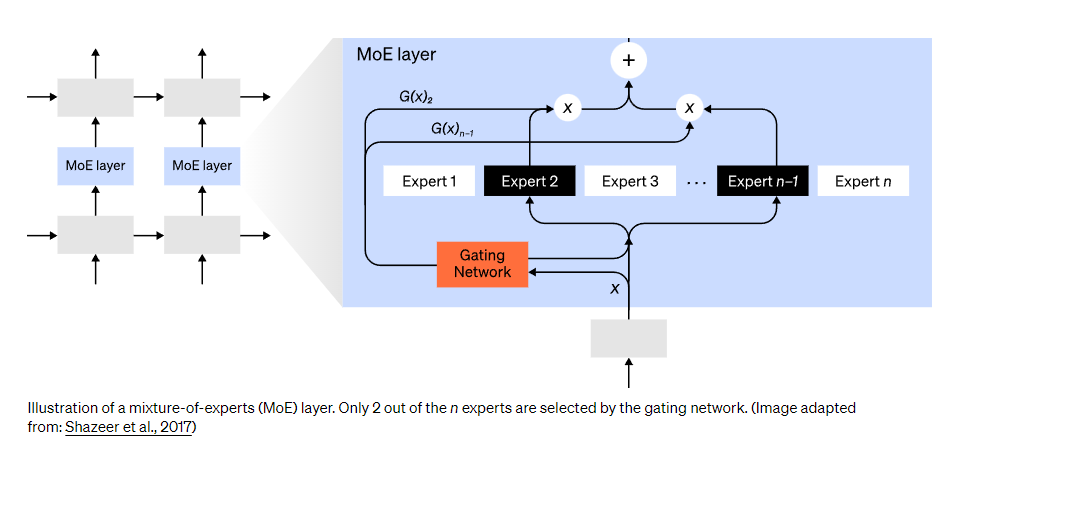

GShard scales an MoE Transformer up to 600 billion parameters with a scheme where only the MoE layers are split across multiple TPU devices and other layers are fully duplicated. Switch Transformer scales model size to trillions of parameters with even higher sparsity by routing one input to a single expert.


## Other ideas

### 1) Checkpointing

Gradient computations requires activations to be saved, which can be a tonne of data. Checkpointing stores a subset of activations, and recomputes intermediate ones Just in time during training.  This saves a lot of memory at the computational cost of at most one additional full forward pass.


### 2) Mixed Precision Training

Train a model at lower precision (FP16 - but this also requires a copy of FP32, please read the paper)
 https://towardsdatascience.com/understanding-mixed-precision-training-4b246679c7c4
 
 First, we know that FP16 uses 16 bits, and FP32 32. So naively, training and lower precision would reduce memory by half and increase speed
 
 FP16 has 16 bits, 1 bit for the sign, 5 bits for the exponent, and 10 bits for the mantissa
 
 FP32 has 32 bits, 1 bit for the sign, 8 bits for the exponent, and 23 bits for the mantissa
 
 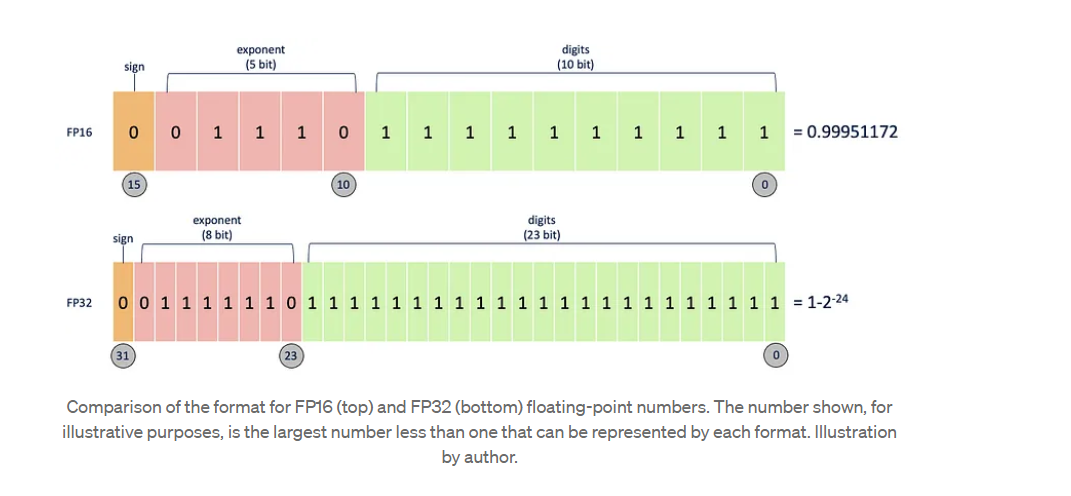
 
 This means that the largest and smallest numbers which can be represented by FP16 and FP32 are
 
 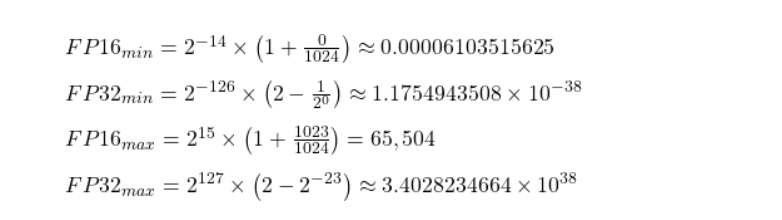
 
 Not completely sure of the formula, check
 
 The absolute smallest number in FP16 which can be represented which some further fudging is   2 ** -24 ~ 6 * 1e-8

This means that there is a consequence of using FP16 instead of FP32 in training , the range of nos which can be represented is smaller, and this needs to be factored in, as this would affect the accuracy of the model in a naive implementation

"To combat this, a master copy of the weights is stored in FP32. This is converted into FP16 during part of each training iteration (one forward pass, back-propagation and weight update). At the end of the iteration, the weight gradients are used to update the master weights during the optimizer step"

The main advantage of this - During gradient update, the learning rates are usually small (O(1e-4 to 1e-6)). So when the learning rates are multipled by the gradients which are also very small, if we get numbers smaller than 2 ** -24, the numbers are set to 0 -> no updates -> bad

Which is why keeping the FP32 copy and updating on that is important

Because both FP16 and FP32 weights are used, it is called mixed precision training

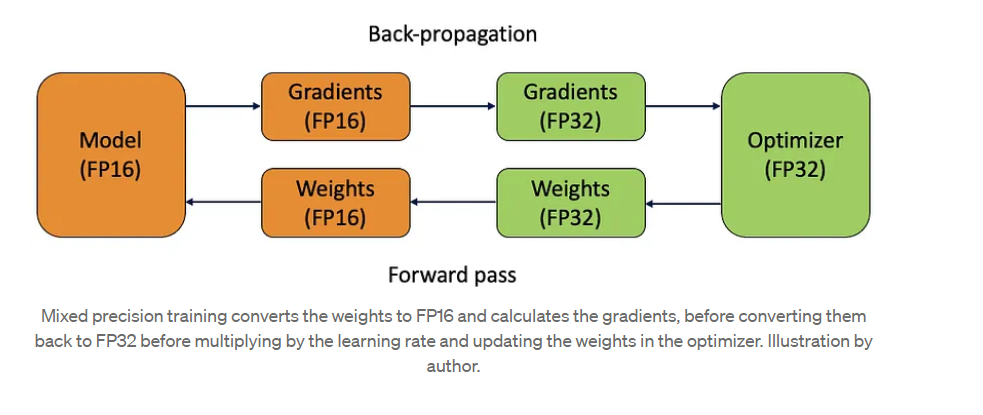

Read from Right to Left !!




There are further improvements to this such as loss scaling . Even before teh learning rate is multiplied by the gradient, if the gradient themselves are < 2 ** -27, research found no impact on accuracy if we set to 0. However, if gradients are between 2 ** (-24) and 2 ** (-27), significant impact if set to 0

The solution is loss caling :   a process by which the loss value is multiplied by a scale factor after the forward pass is completed and before back-propagation. The chain rule dictates that all the gradients are subsequently scaled by the same factor, which moved them within the range of FP16.

Once the gradients have been calculated, they can then be divided by the same scale factor, before being used to update the master weights in FP32

What should be the choice of scaling factor ? Can go as high as we want which doesn't cause an overflow of the max value (the other side :))


Apex - Automatic Mixed Precision, extension to pytorch by NVIDIA in 2018 which makes it very easy to do mixed precision training

Two benefits

1) Reduced training time - Reduced by 1.5X - 5.5X (!!) , without any significant performance degradation

2) Reduced memory requirements (How ? Since you're storing 2 copies - FP32 and FP16)

3) Offloading is to temporarily offload unused data to the CPU or amongst different devices and later read it back when needed (ZeRO uses this idea,  splitting the parameters, gradients, and optimizer states across all available hardware and materializes them as needed.)

the Zero paper (deepspeed) does both Data and model parallelism

Each GPU/worker gets a part of the data, just like data parallelism

Each GPU/worker gets a shard of the mode , just like pipeline parallelism or data parallelism

Now, during forward pass, let's say GPU 1 has data 1 and layer 1 - So forward pass of data 1 will happen through layer 1

All the other GPUs don't have layer 1. So teh weights corresponding to layer 1 alone will be copied to other GPUs, they will do their forward pass with their respective data chunks, and once Forward pass is done, the copied weights will be deleted 

Just like data parallelism, at the end of forward pass, gradients are computed and mean gradient taken using all reduce

The same thing happens in backprop as well, workers will get gradients (and optimizers) which they don't have from other machines, will use them, then get deleted



This is the basic Idea

Details - 



The zero paper measures what contributes to memory consumption in large models

1) Model states - includes optimizer states (momentum, variances in adam), gradients and parameters
2) Residual states - include activation, temp buffer and unusable fragmented memory

Both need different solutions

Both data, tensor, pipeline parallelism maintain all the model states required over the entire training process statically, even though not all model states are required all the time during the training

ZeRO-powered data parallelism is the solution, that achieves the computation/communication efficiency of DP while achieving memory efficiency of MP

1) removes the memory state redundancies across data-parallel processes by partitioning the
model states instead of replicating them (similar to tensor or pipeline parallelism)
2) retains the compute/communication efficiency of DP by retaining the computational granularity and communication volume of DP using a dynamic communication schedule during training

How does this work ?

1) For optimizer states - FOr data parallelism degree Nd, group the optimizer states into Nd equal partitions. Each data parallel process stores and updates only 1/Nd of the optimizer states and updates only 1/Nd of the parameters (huh). all-gather across the data parallel
process at the end of each training step to get the fully updated parameters across all data

2) gradient partition - since  each data parallel process only updates its corresponding parameter partition, it only needs the reduced gradients for the corresponding parameters. Therefore, as each gradient of each layer becomes available during the backward propagation, we only reduce them on the data parallel process responsible for updating the corresponding 

3) Parameter partitioning - Each process (worker) stores only parameters corresponding to its partition. When the parameters outside of its partition are required for
forward and backward propagation, they are received from the appropriate data parallel process
through broadcast. 



4) Memory Efficient Optimizers have been proposed to reduce the memory footprint of the running state maintained by the optimizer (AdaFactor)
5) Compression also can be used for storing intermediate results in the network.

## References

1) https://openai.com/research/techniques-for-training-large-neural-networks - Article by Lilian Weng and Greg Brockman
2) Lilian Weng's original blog - https://lilianweng.github.io/posts/2021-09-25-train-large/
3) The ZeRO paper https://arxiv.org/pdf/1910.02054.pdf and the 
4) All reduce for updating weights in parallel for data parallelism - https://tech.preferred.jp/en/blog/technologies-behind-distributed-deep-learning-allreduce/
5) Checkpointing paper (https://arxiv.org/pdf/1604.06174.pdf)
6) Mixed Precision training - https://arxiv.org/abs/1710.03740
7) ZeRO - https://arxiv.org/pdf/1910.02054.pdf
8) Article on Mixed precision training - https://towardsdatascience.com/understanding-mixed-precision-training-4b246679c7c4